### Análisis de los datos

Este notebook consiste en el análisis de la variable target, análisis bivariante de las features con la variable target y ver cuáles son las mejores features para el modelo.

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import bootcampviztools as bt
from utils import toolbox_ML as tl
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

In [270]:
df = pd.read_csv('./data/df_limpio.csv')
df = df.set_index('sale_date')
df = df.drop(columns='ventas', axis = 1)
df = df.drop(columns = 'id', axis = 1)

In [271]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
sale_date,,,,,,,,,,,,,,,,,,,
2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Análisis de la variable `target`

In [272]:
target = 'price'

train_set, test_set = train_test_split(df, random_state=42, test_size=0.2)

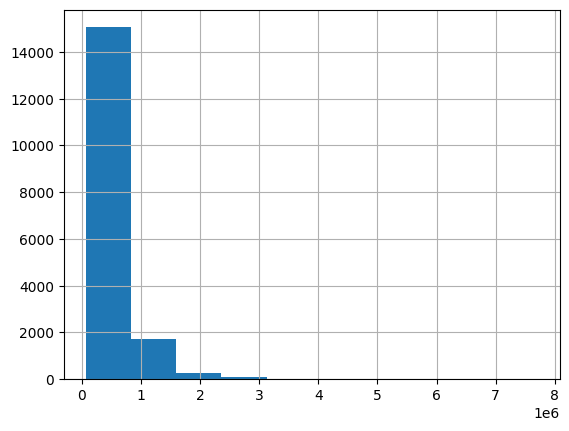

In [273]:
train_set[target].hist();

Nuestra variable target no sigue una distribución normal y presenta una cola hacia la derecha.

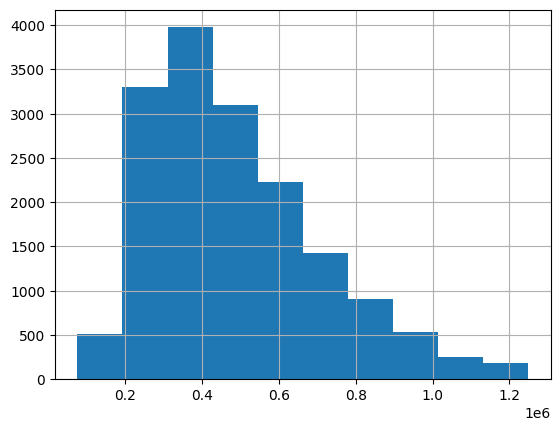

In [274]:
precios_bajos = train_set.loc[train_set[target] < 1250000]
precios_bajos[target].hist();

Analizando la variable `price` se observa que la mayoría de las casas tienen un precio entre 200.000 y 1.000.000 de dólares. Hay algunas casas que superan esos precios con creces, llegando hasta un valor máximo de casi 8.000.000 de dólares. Para mejorar los resultados del modelo aplicaremos una transformación a las variables numéricas que puedan beneficiarse de una transformación.

Haciendo uso de las columnas `lat` y `long` podemos observar geográficamente donde se encuentran las casas en venta del condado de King.

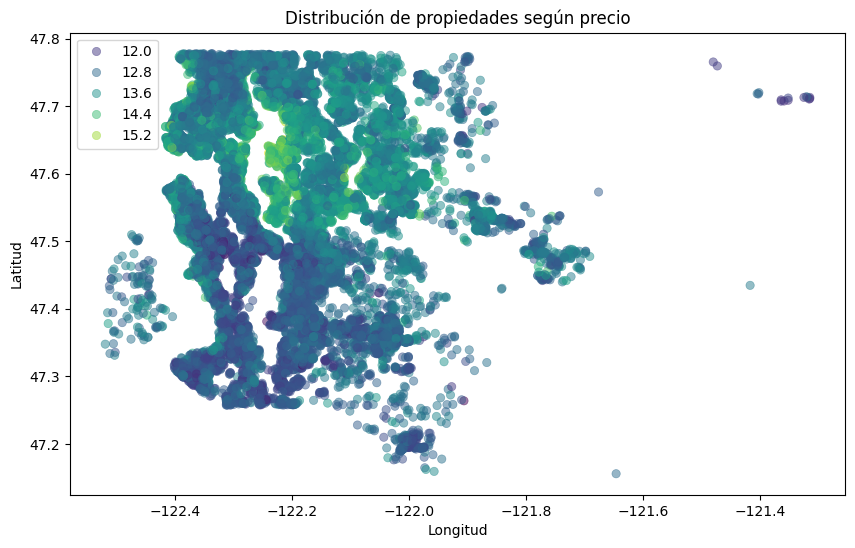

In [275]:
df['precio_venta_log'] = np.log(df['price'])

plt.figure(figsize=(10, 6))

# Normalizar los precios para que los puntos no sean demasiado grandes

sns.scatterplot(x=df['long'], y=df['lat'], alpha=0.5, edgecolor=None, legend=True, hue = df['precio_venta_log'], palette='viridis')

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Distribución de propiedades según precio")
plt.legend()
plt.show()

In [312]:
df.yr_renovated.value_counts(normalize=True)

yr_renovated
0       0.957546
2014    0.004245
2013    0.001726
2003    0.001679
2005    0.001633
          ...   
1951    0.000047
1959    0.000047
1948    0.000047
1954    0.000047
1944    0.000047
Name: proportion, Length: 70, dtype: float64

In [277]:
features_cat = ['bedrooms','waterfront','view','condition','grade','bathrooms','floors','yr_renovated']
features_num = [col for col in train_set.columns if col not in features_cat]

In [278]:
features_num

['price',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [279]:
features = train_set.columns.to_list()

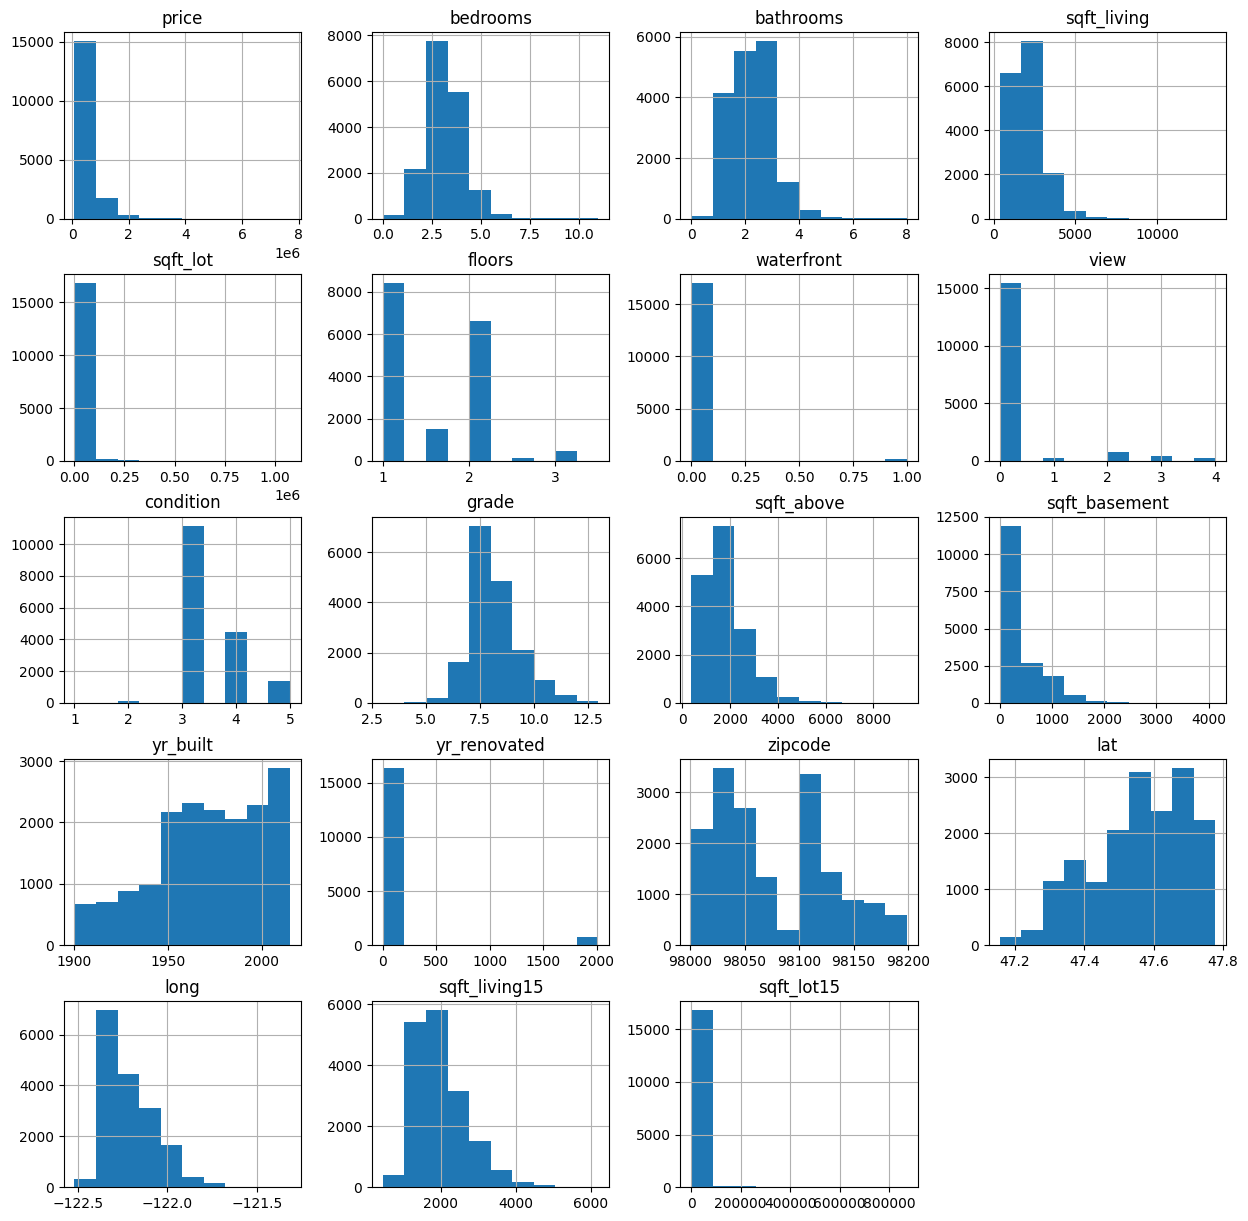

In [280]:
train_set[features].hist(figsize = (15,15));

### Análisis de las ``variables numéricas`` con la target

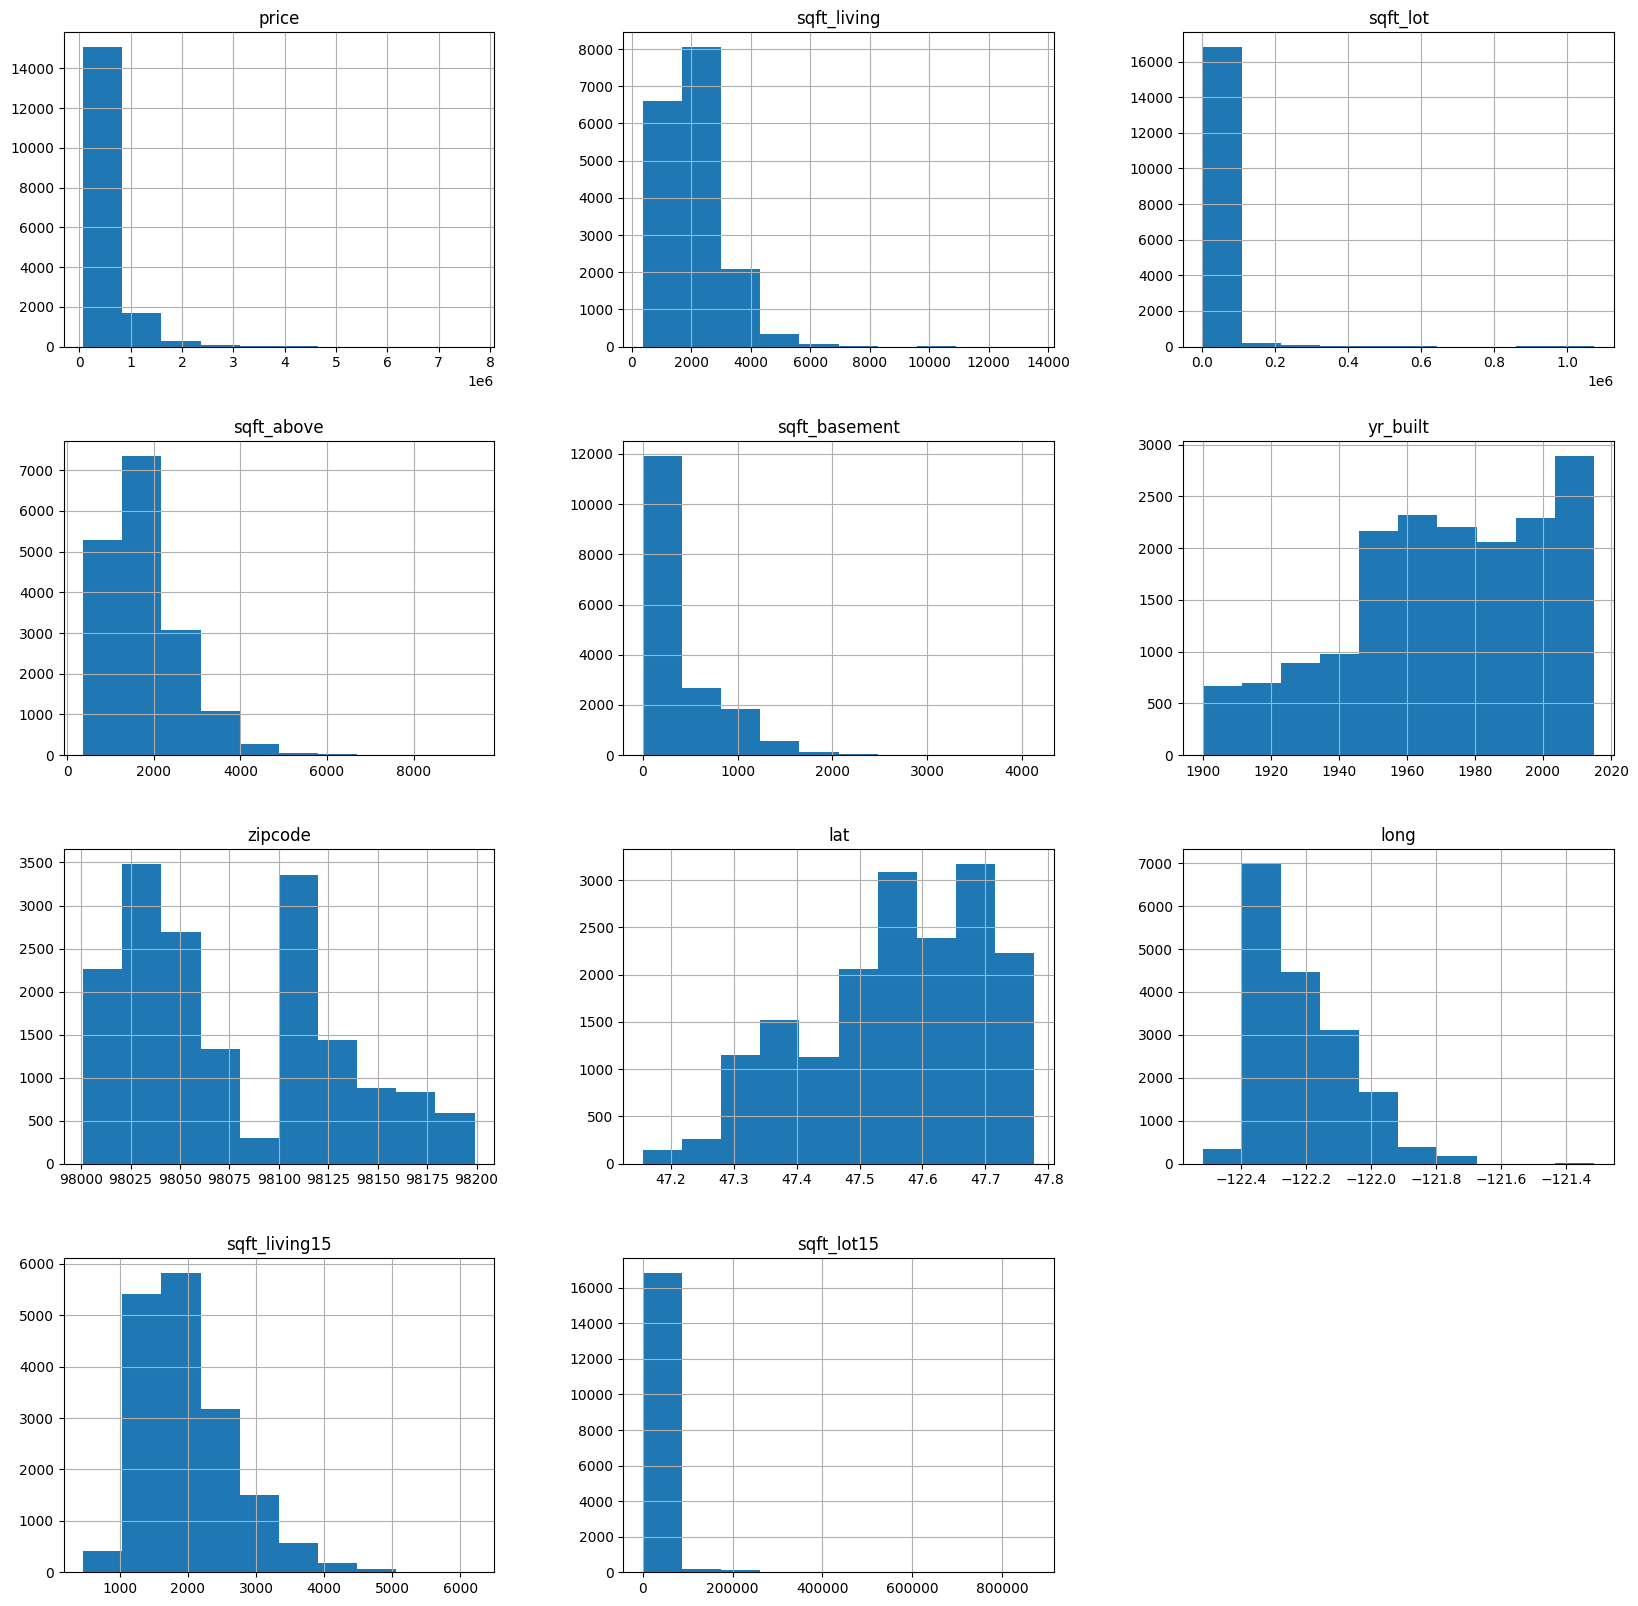

In [281]:
train_set[features_num].hist(figsize=(20,20));

(11, 2)


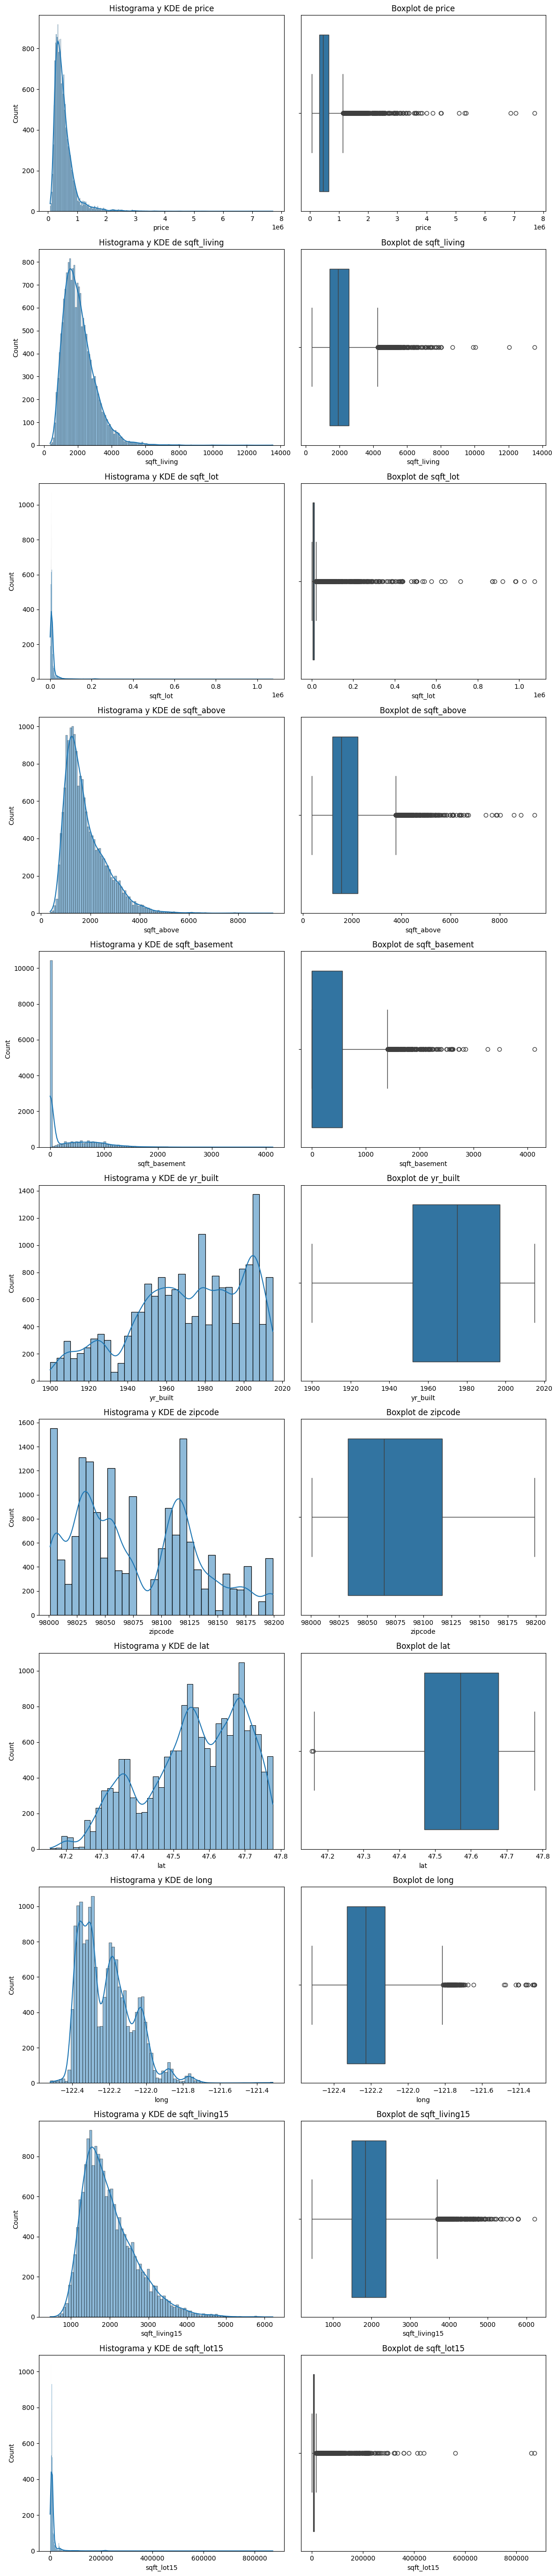

In [282]:
bt.plot_combined_graphs(df = train_set, columns = features_num, whisker_width=1.5)

Hay features que tienen una gran cantidad de ``outliers`` como price, sqft_basement, sqft_living15 y sqft_lot15

### Tratamiento de `outliers`

Como vamos a usar un modelo de regresión lineal, realizaremos un train y test set escalado para este modelo en concreto.

Las features que contienen outliers son: `price, bathrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, yr_renovated, long, sqft_living15, sqft_lot15`. 

- La feature `price` no será transformada para el modelo ya que es la variable target.
- La feature ``long`` no vamos a aplicarle una transformación ya que nos valores fijos establecidos.
- La feature `bathrooms` contiene valores continuos pero son específicos, por lo que para el modelo vamos a categorizar los valores en 4 grupos.

In [283]:
"""Lista con las features que tienen outliers"""
features_outliers = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']

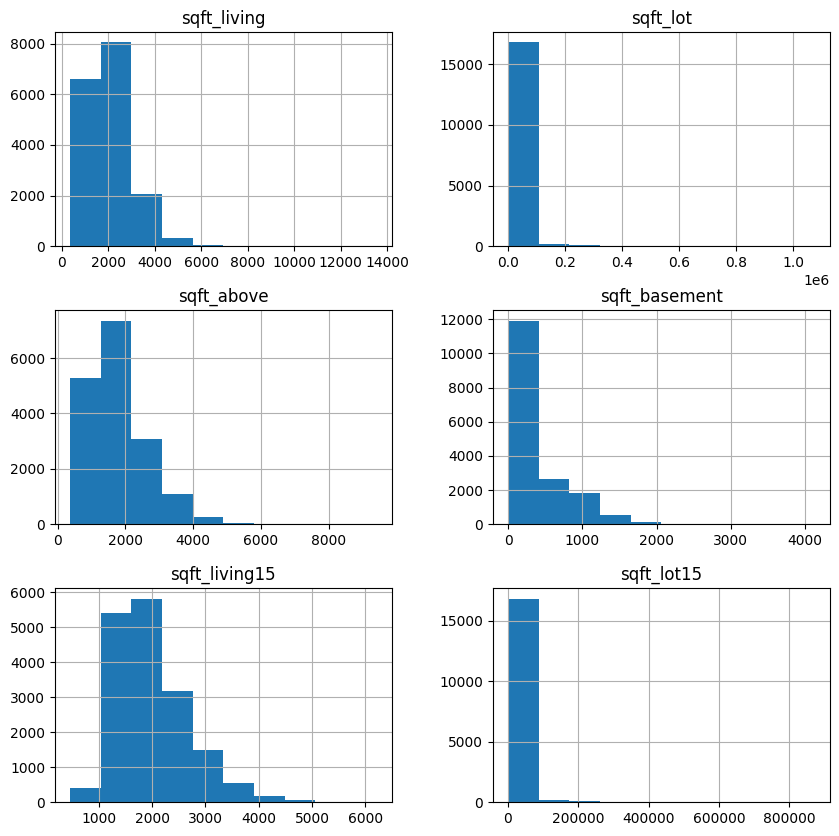

In [284]:
train_set[features_outliers].hist(figsize=(10,10));

In [285]:
features_num.remove(target)

In [286]:
features_num

['sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [287]:
scaler = StandardScaler()

"""Para train set"""
train_set_scaled = train_set.copy()
train_set_scaled[features_outliers] = np.log1p(train_set_scaled[features_outliers])
train_set_scaled[features_outliers] = scaler.fit_transform(train_set_scaled[features_outliers])

"""Para test set"""
test_set_scaled = test_set.copy()
test_set_scaled[features_outliers] = np.log1p(test_set_scaled[features_outliers])
test_set_scaled[features_outliers] = scaler.transform(test_set_scaled[features_outliers])

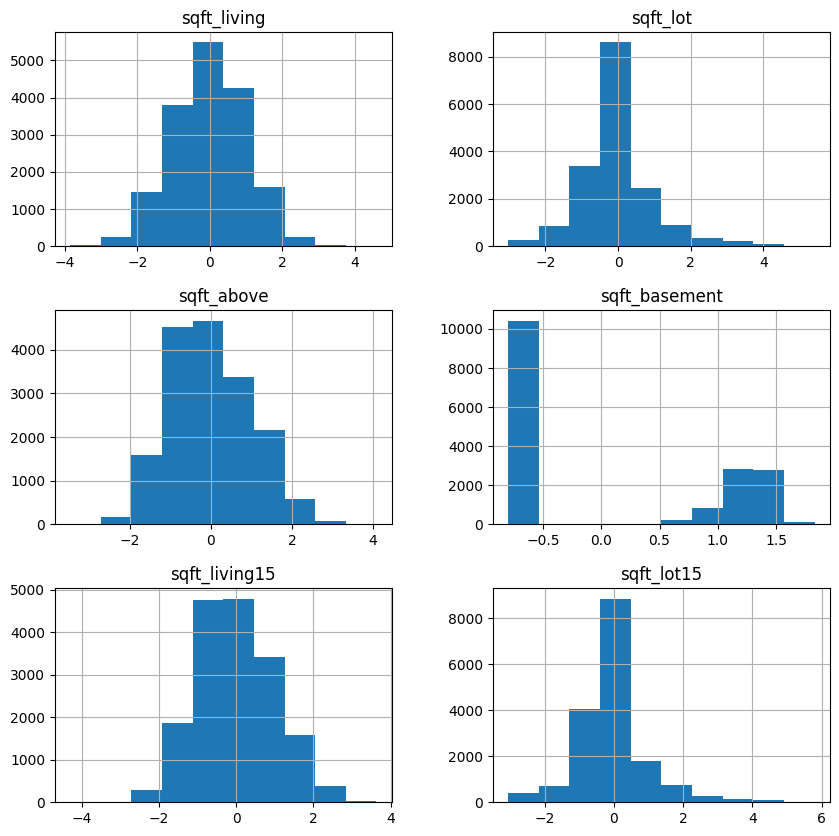

In [288]:
train_set_scaled[features_outliers].hist(figsize=(10,10));

### Correlación de las variables numéricas con la variable target.

Para saber el nivel de correlación que tienen las variables numéricas con la variable target realizaremos la `correlación de Pearson`.

In [289]:
corr = train_set[features_num + [target]].corr()
corr[target].sort_values(ascending=False)

price            1.000000
sqft_living      0.704531
sqft_above       0.609844
sqft_living15    0.585708
sqft_basement    0.323987
lat              0.306618
sqft_lot         0.095893
sqft_lot15       0.083231
yr_built         0.054167
long             0.020907
zipcode         -0.053750
Name: price, dtype: float64

Nos quedaremos con aquellas variables que cumplan el criterio de correlación mínima con la target

In [290]:
pearson_num_features = []
criterio = 0.3
for col in features_num:
    if corr[col][target] > criterio:
        pearson_num_features.append(col)

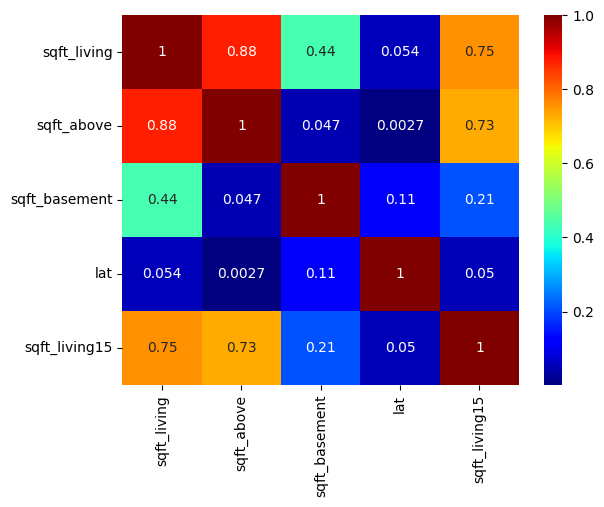

In [291]:
corr_subset = corr[pearson_num_features].loc[pearson_num_features]
sns.heatmap(data = np.abs(corr_subset), cmap='jet', annot=True);

En el heatmap se puede observar que la feature `sqft_living15` tiene una colinealidad alta con las features `sqft_living` y `sqft_above`. Además `sqft_lot` tiene alta colinealidad con `sqft_lot15`. Para no perjudicar al modelo vamos a quitar las features que tengan menor correlación con la target.


In [292]:
pearson_num_features.remove('sqft_above')
# pearson_num_features.remove('sqft_living15')

In [293]:
pearson_num_features

['sqft_living', 'sqft_basement', 'lat', 'sqft_living15']

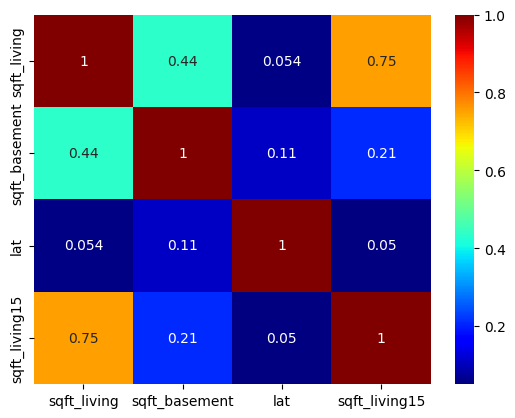

In [294]:
corr_subset = corr[pearson_num_features].loc[pearson_num_features]
sns.heatmap(data = np.abs(corr_subset), cmap='jet', annot=True);

Estas son las variables numéricas que usaremos para los modelos.

### Análisis de las `variables categóricas`

In [295]:
features_cat

['bedrooms',
 'waterfront',
 'view',
 'condition',
 'grade',
 'bathrooms',
 'floors',
 'yr_renovated']

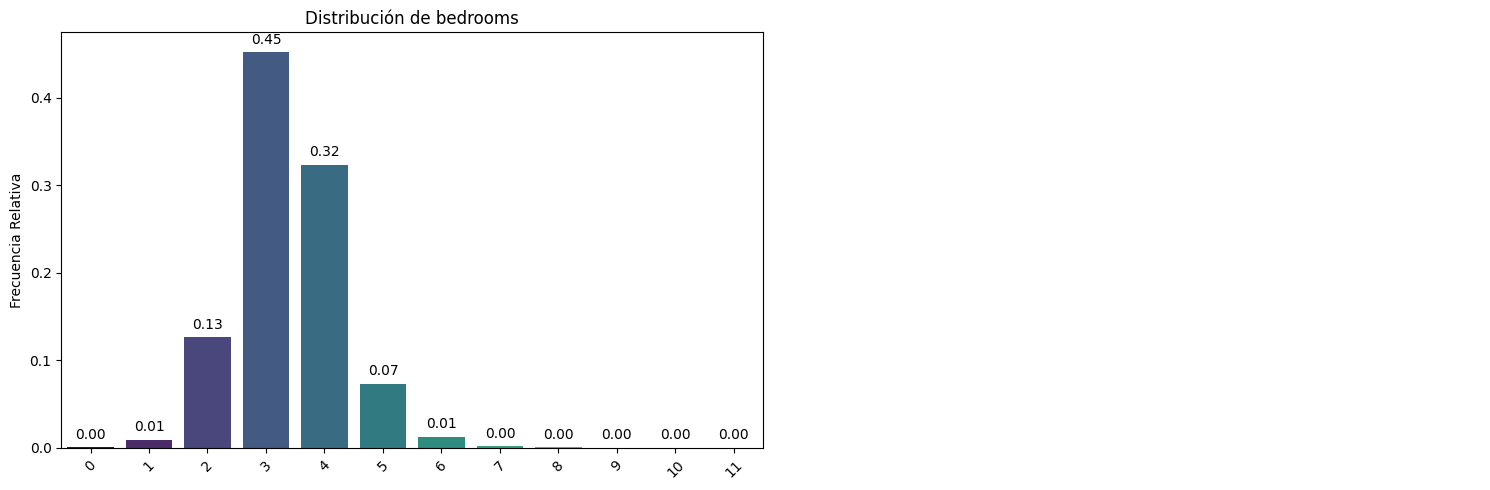

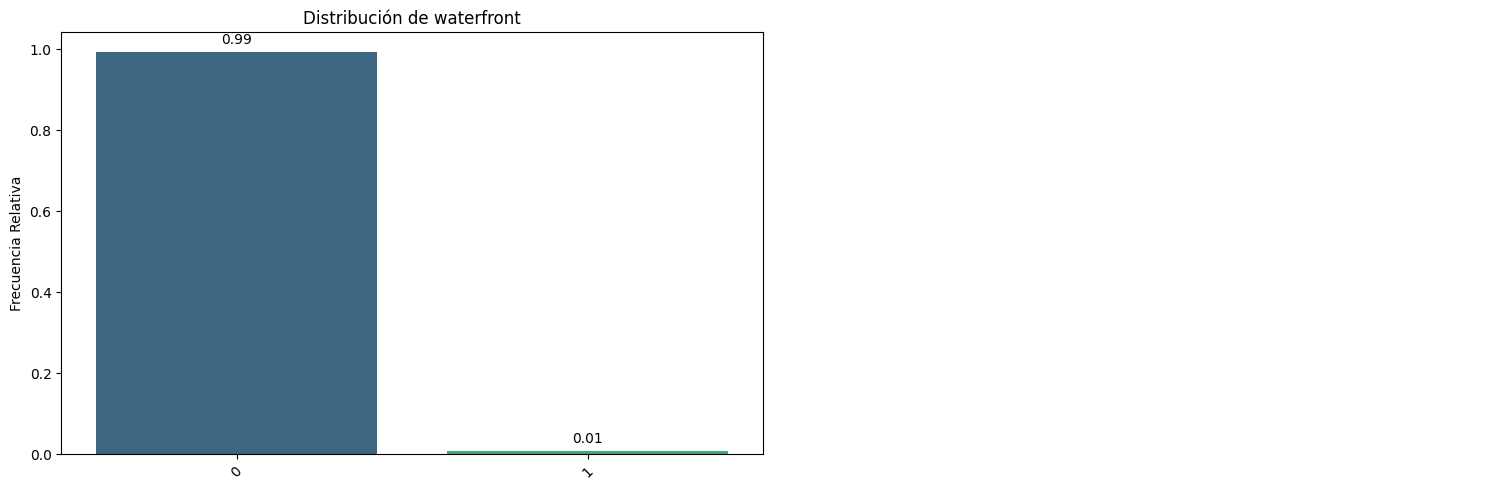

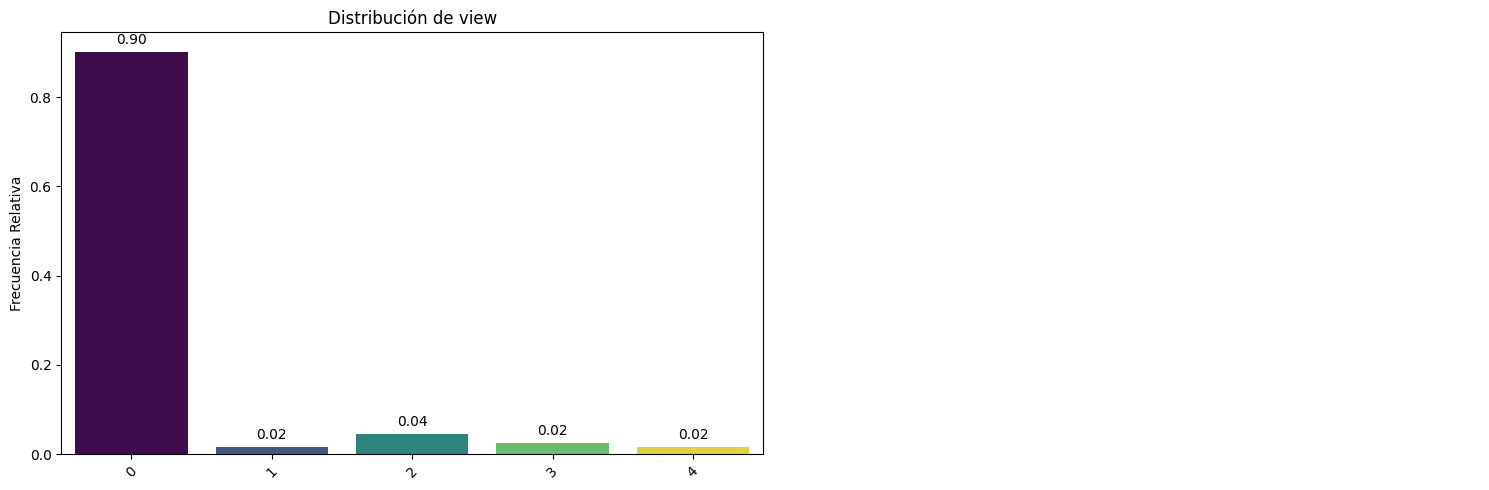

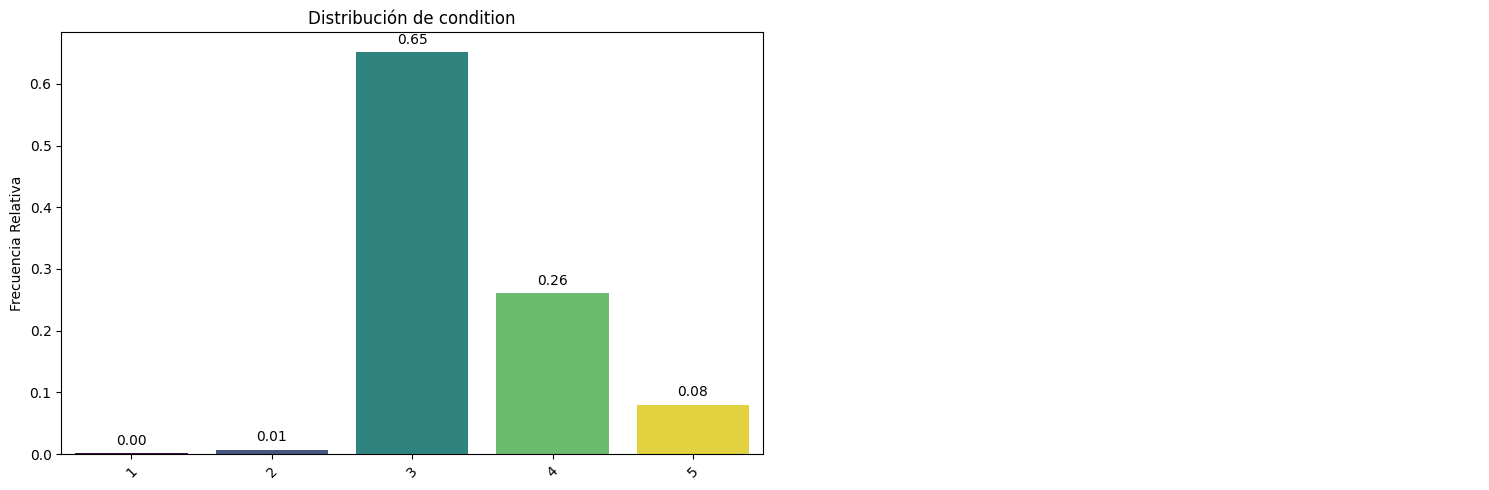

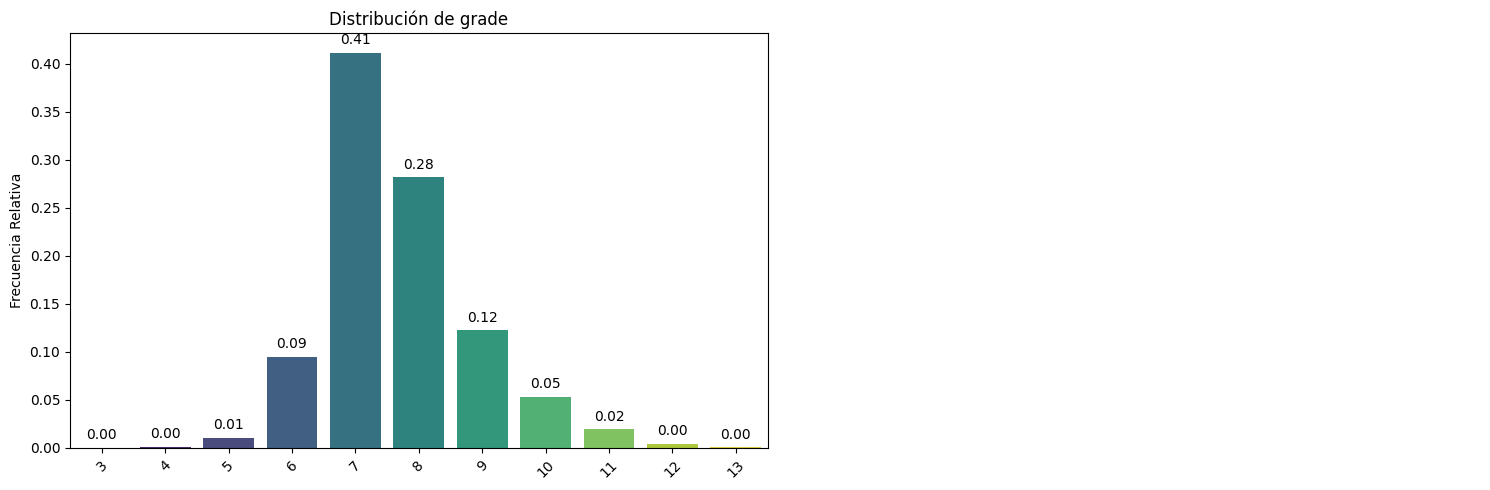

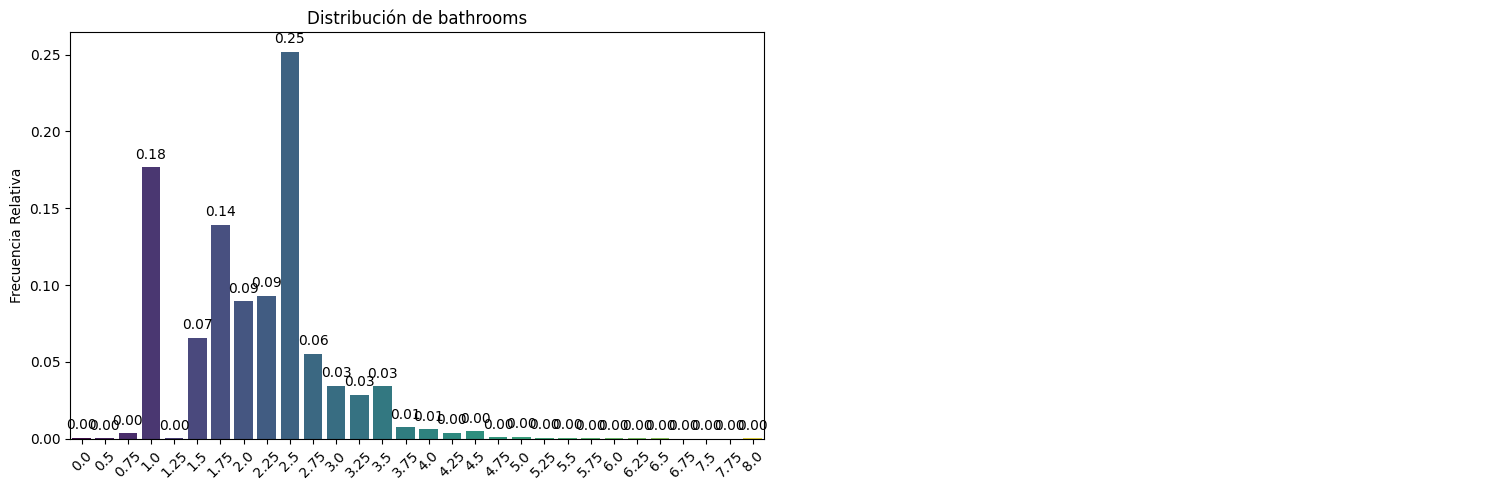

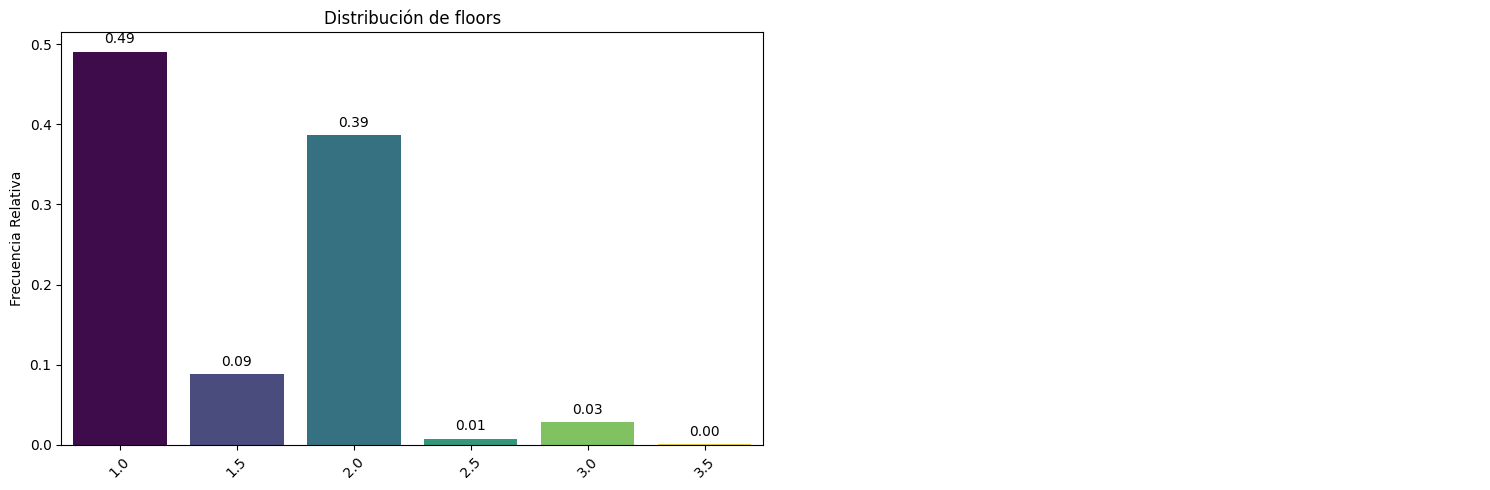

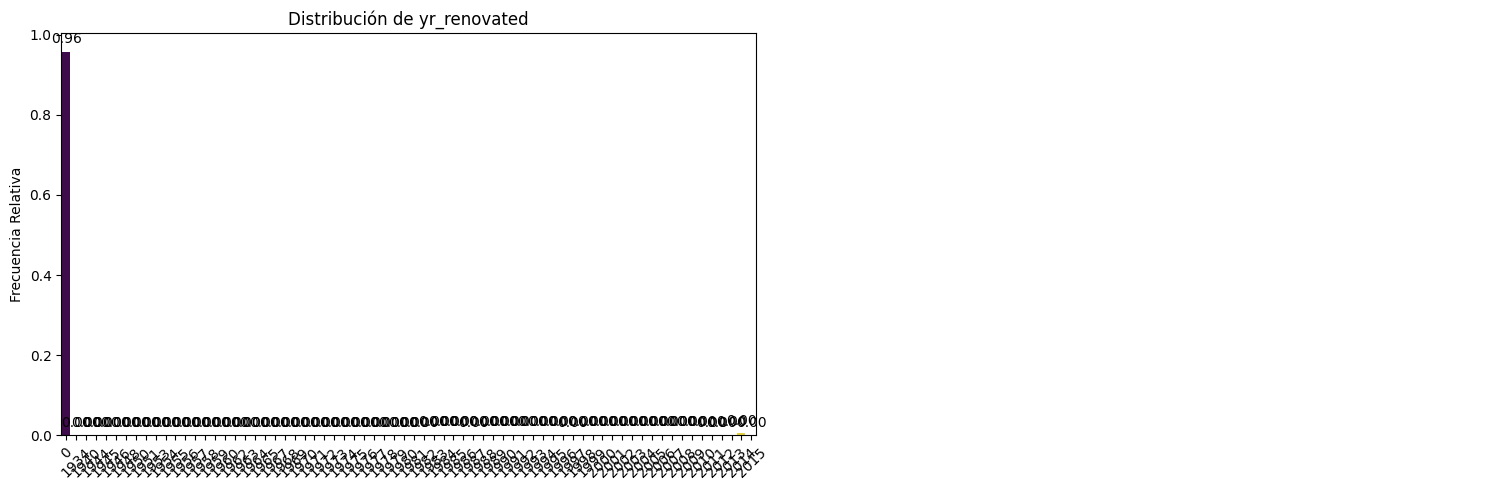

In [296]:
for col in features_cat:
    bt.pinta_distribucion_categoricas(df=train_set, columnas_categoricas=[col], relativa=True, mostrar_valores=True)

La feature `bathrooms` tiene demasiados valores. Vamos a agruparlos en 4 grupos para que haya menos valores categóricos. Ocurre algo similar con la feature `yr_renovated`, esta vamos a convertirla en binaria ya que la mayoría de los valores son 0 y el resto serán = 1.

In [297]:
"""Conversión de la feature 'yr_renovated' en categórica: Ha sido reformada (1) o no (0)"""

train_set["reformada"] = (train_set["yr_renovated"] != 0).astype(int)
test_set["reformada"] = (test_set["yr_renovated"] != 0).astype(int)
features_cat.append('reformada')

In [298]:
# """Pasar los valores de la feature 'floor' a enteros para usarla como categórica"""
# """Para train set"""
# train_set.loc[train_set['floors'] == 1, 'floors_cat'] = 0  # Una planta
# train_set.loc[train_set['floors'] == 1.5, 'floors_cat'] = 1  # Planta y media
# train_set.loc[train_set['floors'] == 2, 'floors_cat'] = 2  # Dos plantas
# train_set.loc[train_set['floors'] == 2.5, 'floors_cat'] = 3  # Dos plantas y media
# train_set.loc[train_set['floors'] == 3, 'floors_cat'] = 4  # Tres plantas
# train_set.loc[train_set['floors'] == 3.5, 'floors_cat'] = 5  # Tres plantas y media

# """Para test set"""
# test_set.loc[test_set['floors'] == 1, 'floors_cat'] = 0
# test_set.loc[test_set['floors'] == 1.5, 'floors_cat'] = 1
# test_set.loc[test_set['floors'] == 2, 'floors_cat'] = 2
# test_set.loc[test_set['floors'] == 2.5, 'floors_cat'] = 3
# test_set.loc[test_set['floors'] == 3, 'floors_cat'] = 4
# test_set.loc[test_set['floors'] == 3.5, 'floors_cat'] = 5

# features_cat.append('floors_cat')

In [299]:
"""Convertir la feature 'bathroom' en una categórica de 4 grupos"""
"""Para train set"""
train_set.loc[train_set['bathrooms'] <= 1.25, 'bathrooms_cat'] = 0  # Pocos baños
train_set.loc[(train_set['bathrooms'] > 1.25) & (train_set['bathrooms'] <= 2.5), 'bathrooms_cat'] = 1  # Estándar
train_set.loc[(train_set['bathrooms'] > 2.5) & (train_set['bathrooms'] <= 3.75), 'bathrooms_cat'] = 2  # Grandes
train_set.loc[train_set['bathrooms'] > 3.75, 'bathrooms_cat'] = 3  # Lujo

"""Para test set"""
test_set.loc[test_set['bathrooms'] <= 1.25, 'bathrooms_cat'] = 0  # Pocos baños
test_set.loc[(test_set['bathrooms'] > 1.25) & (test_set['bathrooms'] <= 2.5), 'bathrooms_cat'] = 1  # Estándar
test_set.loc[(test_set['bathrooms'] > 2.5) & (test_set['bathrooms'] <= 3.75), 'bathrooms_cat'] = 2  # Grandes
test_set.loc[test_set['bathrooms'] > 3.75, 'bathrooms_cat'] = 3  # Lujo

features_cat.append('bathrooms_cat')

In [300]:
features_cat.remove('bathrooms')
# features_cat.remove('floors')
features_cat.remove('yr_renovated')

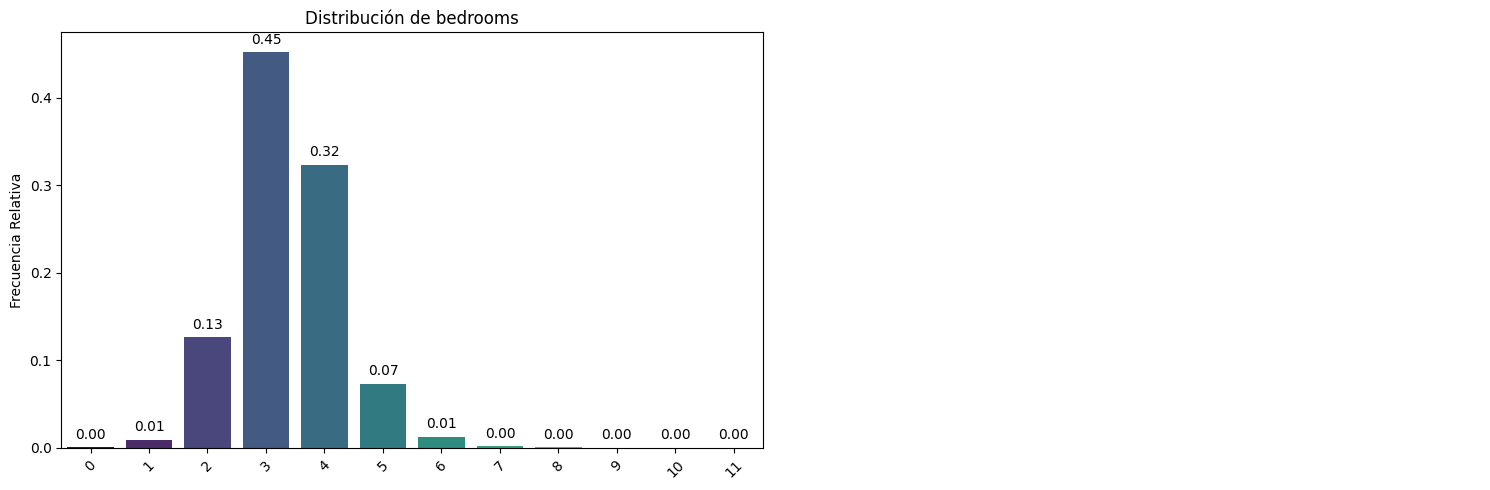

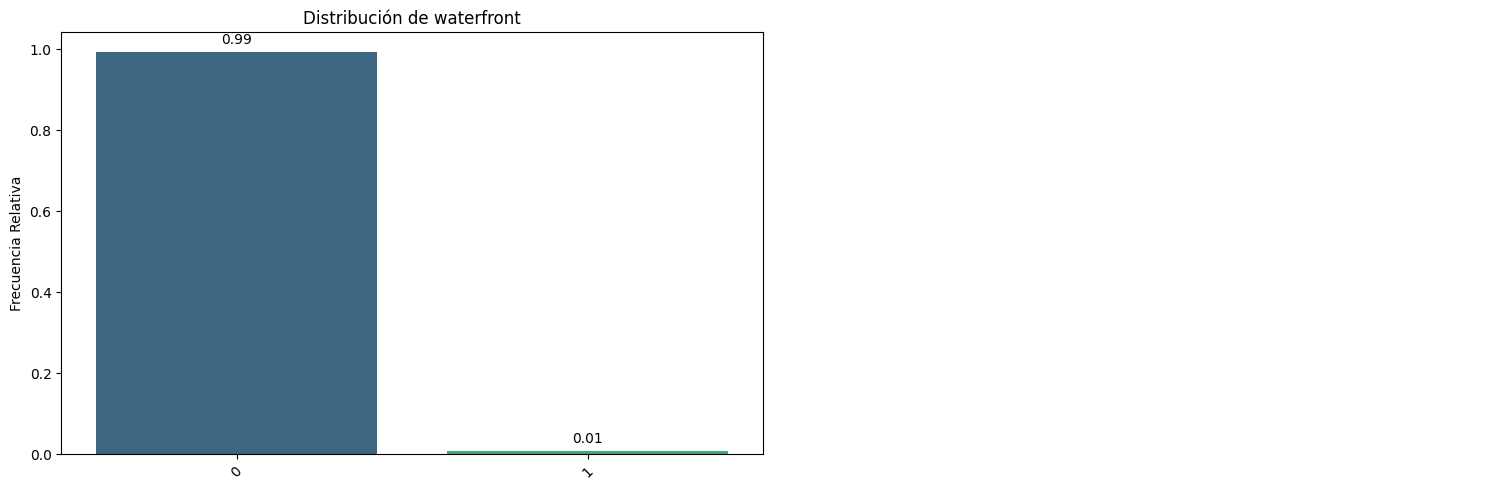

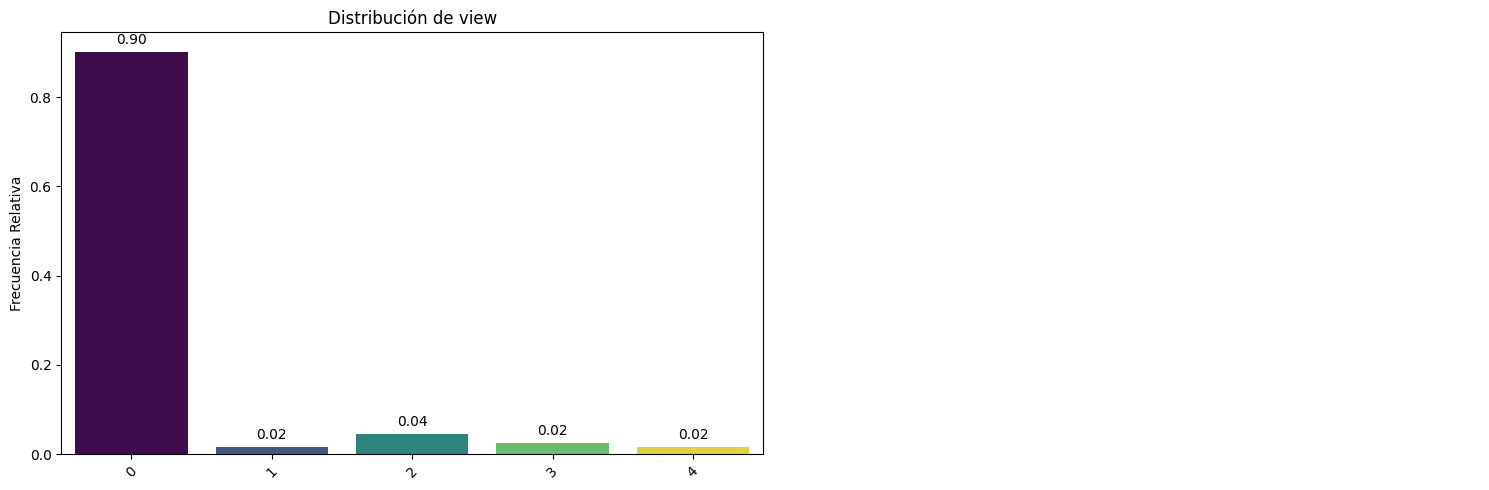

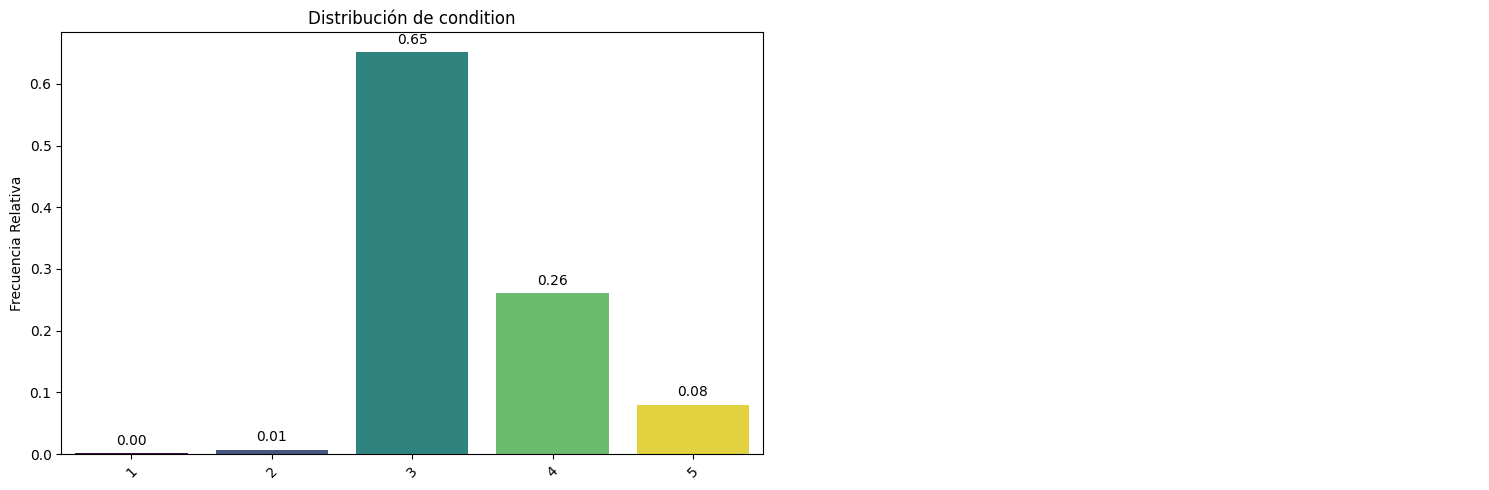

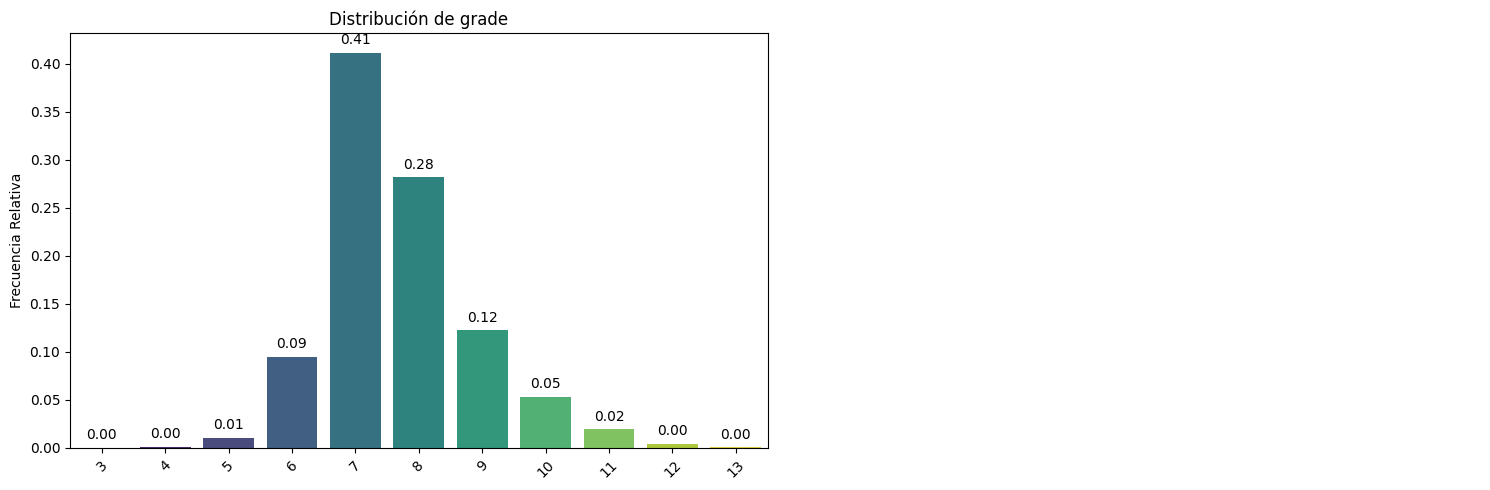

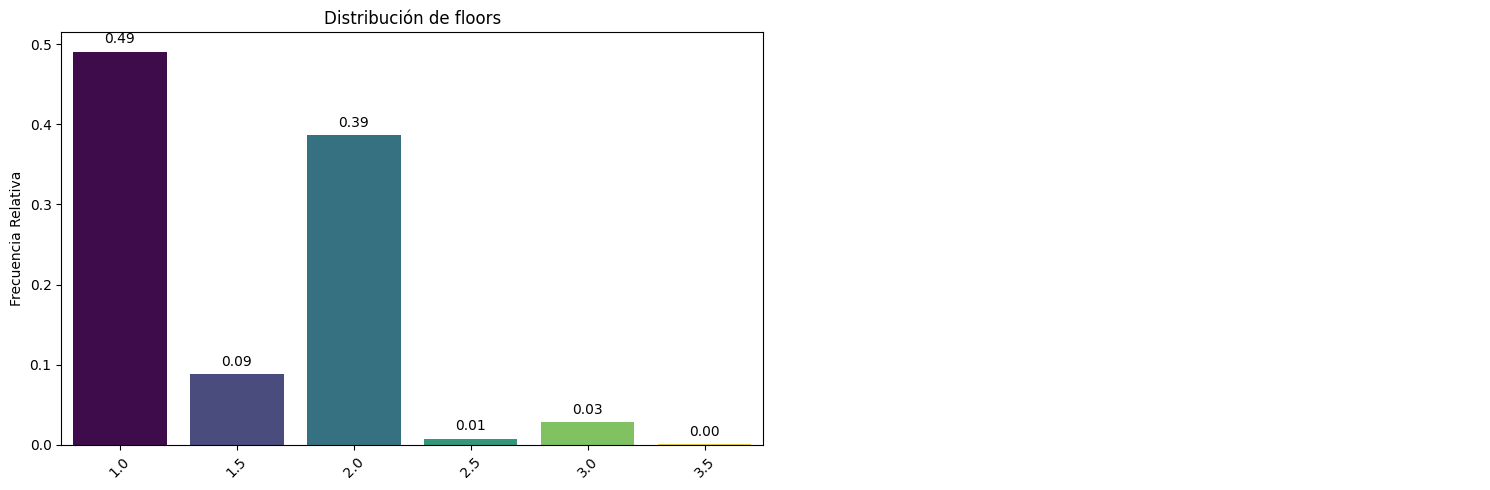

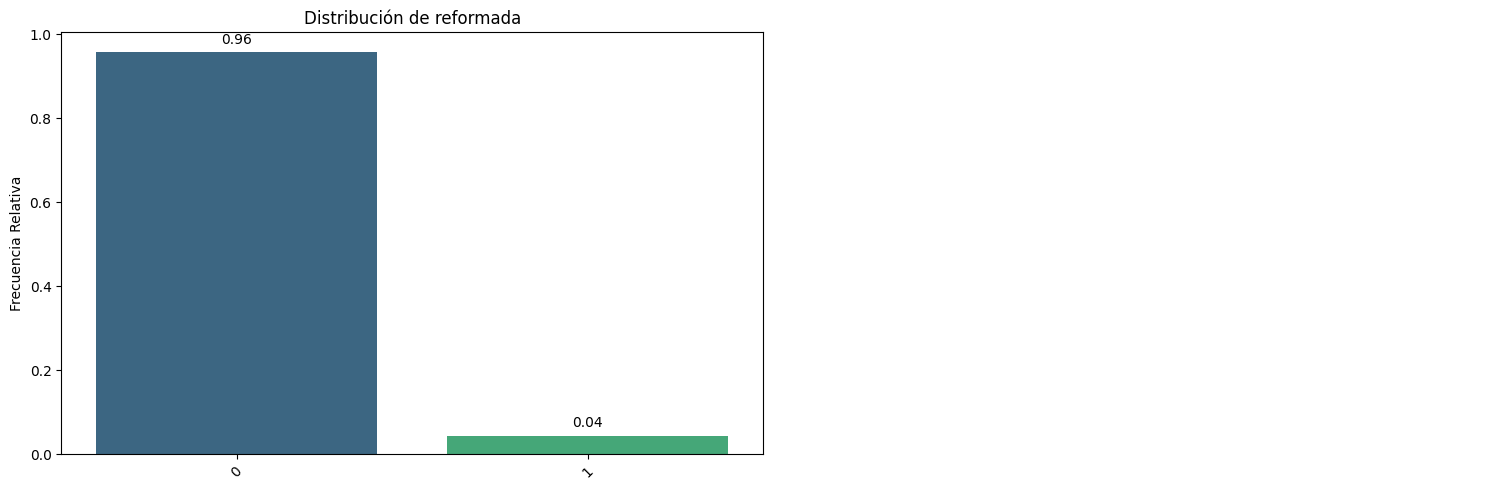

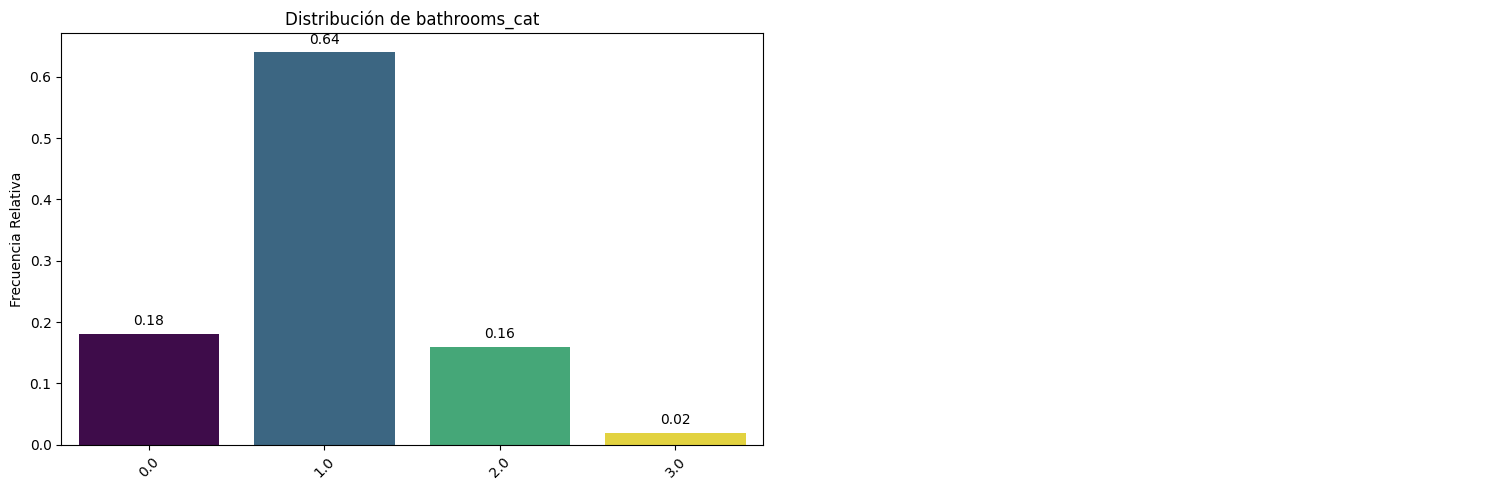

In [301]:
for col in features_cat:
    bt.pinta_distribucion_categoricas(df=train_set, columnas_categoricas=[col], relativa=True, mostrar_valores=True)

Para saber la correlación de las variables categóricas con la variable target usaremos el método `ANOVA`.

In [302]:
features_cat

['bedrooms',
 'waterfront',
 'view',
 'condition',
 'grade',
 'floors',
 'reformada',
 'bathrooms_cat']

In [303]:
from scipy.stats import f_oneway

anova_results = {}

for cat in features_cat:
    groups = [train_set[target][train_set[cat] == val] for val in train_set[cat].unique()]
    f_stat, p_value = f_oneway(*groups)
    anova_results[cat] = p_value

anova_df = pd.DataFrame.from_dict(anova_results, orient='index', columns=['p_value'])
anova_df

,p_value
bedrooms,0.000000e+00
waterfront,3.150865e-270
view,0.000000e+00
condition,2.614515e-23
grade,0.000000e+00
floors,0.000000e+00
reformada,7.410054e-61
bathrooms_cat,0.000000e+00


Todas las variables categóricas han obtenido un ``p_value`` inferior a **0.05**, por lo que tienen una relación estadísticamente significativa con la variable target. Nos quedamos todas las features categóricas para los modelos.

In [304]:
features_selected = features_cat + pearson_num_features
features_selected

['bedrooms',
 'waterfront',
 'view',
 'condition',
 'grade',
 'floors',
 'reformada',
 'bathrooms_cat',
 'sqft_living',
 'sqft_basement',
 'lat',
 'sqft_living15']

In [305]:
"""Combinar las columnas categóricas que he transformado para el train y test set escalado"""
train_set_scaled = pd.concat([train_set_scaled, train_set[['bathrooms_cat', 'reformada']]], axis=1)
test_set_scaled = pd.concat([test_set_scaled, test_set[['bathrooms_cat','reformada']]], axis = 1)

In [306]:
"""X  e y de train set"""
x_train = train_set.drop(columns=target, axis = 1)
y_train = train_set[target]

"""X e y de test set"""
x_test = test_set.drop(columns=target, axis = 1)
y_test = test_set[target]

"""X e y de train set escalado"""
x_train_scaled = train_set_scaled.drop(columns=target, axis = 1)
y_train_scaled = train_set_scaled[target]

"""X e y de test set escalado"""
x_test_scaled = test_set_scaled.drop(columns=target, axis = 1)
y_test_scaled = test_set_scaled[target]

### Comparación de modelos

Una vez analizadas las variables vamos a escoger tres modelos regresores para saber cómo predice.

In [307]:
rf_reg = RandomForestRegressor(random_state=42, max_depth=8)
lr = LinearRegression()
xgb_reg = XGBRegressor(random_state = 42, max_depth = 8)
lgbm_reg = LGBMRegressor(random_state=42, max_depth=8)

In [308]:
models = [
    ('RF_reg', rf_reg),
    ('Linear Regression', lr),
    ('XGB_reg', xgb_reg),
    ('LGMB_reg', lgbm_reg)
]
model_names = ['RF_reg','Linear Regression','xgb_reg']

results = []

# Bucle para recorrer los modelos
for name, model in models:
    print(f"Evaluando el modelo: {name}")

    # Si el modelo es Linear Regression, usar los conjuntos escalados
    if name == 'Linear Regression':
        x_train_model = x_train_scaled[features_selected]  # x_train escalado
        x_test_model = x_test_scaled[features_selected]    # x_test escalado
    else:
        x_train_model = x_train[features_selected]
        x_test_model = x_test[features_selected]

    # Evaluación con Cross-Validation para obtener el RMSE
    cv_rmse = np.sqrt(-cross_val_score(model, x_train_model, y_train, cv=5, scoring='neg_mean_squared_error'))
    
    # Entrenamiento del modelo
    model.fit(x_train_model, y_train)
    
    # Predicciones en el conjunto de test
    y_pred = model.predict(x_test_model)
    
    # Cálculo de MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    # Cálculo de MAPE
    mape = np.mean(np.abs((y_test - y_pred) / y_test))  # Porcentaje de error medio
    
    # Almacenar resultados
    results.append({
        'Model': name,
        'RMSE (Cross-Val)': np.mean(cv_rmse),
        'MAPE': mape,
        'MAE': mae
    })

# Mostrar los resultados
results_df = pd.DataFrame(results)
print(results_df)

Evaluando el modelo: RF_reg
Evaluando el modelo: Linear Regression
Evaluando el modelo: XGB_reg
Evaluando el modelo: LGMB_reg
               Model  RMSE (Cross-Val)      MAPE            MAE
0             RF_reg     169728.142477  0.174846   92615.622865
1  Linear Regression     227920.418861  0.289518  136406.319362
2            XGB_reg     161256.820916  0.159122   84118.333585
3           LGMB_reg     158713.494717  0.157475   82452.269311


In [309]:
original_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_lot15']

In [310]:
models = [
    ('RF_reg', rf_reg),
    ('Linear Regression', lr),
    ('XGB_reg', xgb_reg),
    ('LGBM_reg', lgbm_reg)
]

results = []

# Bucle para recorrer los modelos
for name, model in models:
    print(f"Evaluando el modelo: {name}")

    # Si el modelo es Linear Regression, usar los conjuntos escalados
    if name == 'Linear Regression':
        x_train_model = x_train_scaled[original_features]  # x_train escalado
        x_test_model = x_test_scaled[original_features]   # x_test escalado
    else:
        x_train_model = x_train[original_features]
        x_test_model = x_test[original_features]

    # Evaluación con Cross-Validation para obtener el RMSE
    cv_rmse = np.sqrt(-cross_val_score(model, x_train_model, y_train, cv=5, scoring='neg_mean_squared_error'))
    
    # Entrenamiento del modelo
    model.fit(x_train_model, y_train)
    
    # Predicciones en el conjunto de test
    y_pred = model.predict(x_test_model)
    
    # Cálculo de MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    # Cálculo de MAPE
    mape = np.mean(np.abs((y_test - y_pred) / y_test))  # Porcentaje de error medio
    
    results.append({
        'Model': name,
        'RMSE (Cross-Val)': np.mean(cv_rmse),
        'MAPE': mape,
        'MAE': mae
    })

results_df = pd.DataFrame(results)
print(results_df)

Evaluando el modelo: RF_reg
Evaluando el modelo: Linear Regression
Evaluando el modelo: XGB_reg
Evaluando el modelo: LGBM_reg
               Model  RMSE (Cross-Val)      MAPE            MAE
0             RF_reg     148934.520530  0.159767   81226.080929
1  Linear Regression     215582.881078  0.278775  130556.164336
2            XGB_reg     136814.419021  0.126641   64807.727633
3           LGBM_reg     130069.165401  0.127685   65049.988683


In [214]:
pd.DataFrame(data = xgb_reg.feature_importances_, index = x_train_model[original_features].columns).sort_values(by = 0, ascending=False)

,0
grade,0.469230
waterfront,0.198346
sqft_living,0.109114
lat,0.061728
view,0.047861
long,0.035315
zipcode,0.015879
yr_built,0.012378
yr_renovated,0.008740
sqft_lot15,0.006936


### Mejora del modelo con las mejores métricas

In [215]:
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(x_train[features_selected], y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

El modelo que ha obtenido mejores resultados es el `XGBoost`

In [216]:
params_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Cuanto más bajo, más lento pero mejor ajuste
    'max_depth': [3, 6, 9, 12],  # Profundidad de los árboles
    'n_estimators': [100, 500, 1000],  # Número de árboles
}

model_gridsearch = GridSearchCV(
    estimator=xgb_reg,
    cv = 5,
    param_grid= params_grid,
    scoring='neg_mean_squared_error'
)
model_gridsearch.fit(x_train[features_selected], y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 6, 9, 12],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [217]:
np.sqrt(-model_gridsearch.best_score_)

157458.554861266